<h1 style="text-align:center;font-size:200%;">Лабораторная работа №1</h1>
<h2 style="text-align:center;">Разведочный анализ данных с помощью PySpark</h2>

### Цели работы:
1. Познакомиться с понятием «большие данные» и способами их обработки;
2. Познакомиться с инструментом `Apache Spark` и возможностями, которые он предоставляет для обработки больших данных;
3. Получить навыки выполнения разведочного анализа данных использованием `pyspark`.

### Постановка задачи
Выполнить разведочный анализ датасета согласно варианту с определением: 
* типов признаков в датасете; 
* пропущенных значений и их устранением; 
* выбросов и их устранением; 
* расчетом статистических показателей признаков (средних, квартилей и т.д.); 
* визуализацией распределения наиболее важных признаков; 
* корреляций между признаками.

Вариант №2: "Датасет авиабилетов из Expedia".

Источник: https://www.kaggle.com/datasets/dilwong/flightprices

## Содержание <a class="anchor" id="content"></a>
1. [Инициализация PySpark фреймворка и загрузка данных в датафрейм pyspark](#1);
2. [Обзор датасета](#2);
3. [Определение пропущенных и аномальных нулевых значений](#3);
4. [Расчет статистических показателей признаков](#4);
5. [Определение выбросов](#5);
6. [Корреляции между признаками](#6).

### **1. Инициализация PySpark фреймворка и загрузка данных в датафрейм pyspark** <a class="anchor" id="1"></a>

[Перейти к содержанию](#content)

In [43]:
# Import other modules not related to PySpark
import os
import sys
import copy
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
import pylab 
import scipy.stats as scipy_stats

# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [44]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row, DataFrame, SparkSession, SQLContext, functions, Window
from pyspark.sql.types import DoubleType
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.sql.functions import lit, desc, col, size, array_contains, row_number, \
isnan, udf, hour, array_min, array_max, countDistinct, median, collect_list, \
max as col_max, mean as col_mean, min as col_min, stddev, monotonically_increasing_id
from pyspark.sql.types import *

MAX_MEMORY = '15G'

# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = '../data/itineraries_mini.csv'

# Load the main data set into pyspark data frame 
df = spark \
    .read \
    .options(inferSchema='True', header='True', delimeter=',') \
    .csv(filename_data, mode='DROPMALFORMED')
print('Data frame type: ' + str(type(df)))

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>


### 2. Обзор датасета <a class="anchor" id="2"></a>

[Перейти к содержанию](#content)

#### Информация о датасете
Датасет содержит информацию о ценах на полеты в одну сторону самолетами согласно Expedia на период с 16.04.2022 до 05.10.2022.

Датасет представляет собой CSV-файл, где каждая строка - купленный билет в/из следующих аэропортов: ATL, DFW, DEN, ORD, LAX, CLT, MIA, JFK, EWR, SFO, DTW, BOS, PHL, LGA, IAD, OAK.

Данные содержат следующую информацию:
- legId: Идентификатор рейса;
- searchDate: Дата (YYYY-MM-DD), когда эта запись была взята из Expedia;
- flightDate: Дата (YYYY-MM-DD) полета;
- startingAirport: Трехзначный код аэропорта IATA для начального местоположения;
- destinationAirport: Трехзначный код аэропорта IATA для места прибытия;
- fareBasisCode: [Код базового тарифа](https://en.wikipedia.org/wiki/Fare_basis_code);
- travelDuration: Продолжительность поездки в часах и минутах;
- elapsedDays: Количество прошедших дней (обычно 0);
- isBasicEconomy: Логическое значение, указывающее, предназначен ли билет для базовой экономики;
- isRefundable: Логическое значение, указывающее, подлежит ли билет возврату;
- isNonStop: Логическое значение, определяющее, является ли полет беспосадочным;
- baseFare: Цена билета (в долларах США);
- totalFare: Цена билета (в долларах США), включая налоги и другие сборы;
- seatsRemaining: Целое число для количества оставшихся мест;
- totalTravelDistance: Общее расстояние путешествия в милях, иногда эти данные отсутствуют;
- segmentsDepartureTimeEpochSeconds: Строка, содержащая время отправления (время Unix) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsDepartureTimeRaw: Строка, содержащая время отправления (формат ISO 8601: ГГГГ-ММ-ДДТчч:мм:сс.000±[чч]:00) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsArrivalTimeEpochSeconds: Строка, содержащая время прибытия (время Unix) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsArrivalTimeRaw: Строка, содержащая время прибытия (формат ISO 8601: ГГГГ-ММ-ДДТчч:мм:сс.000±[чч]:00) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsArrivalAirportCode: Строка, содержащая код аэропорта IATA для места прибытия для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsDepartureAirportCode: Строка, содержащая код аэропорта IATA для места отправления для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsAirlineName: Строка, содержащая название авиакомпании, обслуживающей каждый этап поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsAirlineCode: Строка, содержащая двухбуквенный код авиакомпании, обслуживающей каждый этап поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsEquipmentDescription: Строка, содержащая тип самолета, используемого на каждом этапе путешествия (например, «Airbus A321» или «Boeing 737-800»). Записи для каждой из ветвей разделяются знаком «||»;
- segmentsDurationInSeconds: Строка, содержащая продолжительность полета (в секундах) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsDistance: Строка, содержащая пройденное расстояние (в милях) для каждого этапа поездки. Записи для каждой из ветвей разделяются знаком «||»;
- segmentsCabinCode: Строка, содержащая салон для каждого этапа поездки (например, «пассажирский»). Записи для каждой из ветвей разделяются знаком «||».

#### Схема, колонки и типы данных датасета:
Данные представляют собой одиночные значения следующих типов данных: `integer`, `double`, `string`, `date`, `boolean`.

In [45]:
print('Data overview')
df.printSchema()

print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name', 'Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


In [46]:
print('Data frame describe (string and numeric columns only):')
df.describe().toPandas()

print(f'There are total {df.count()} row, Let print first 2 data rows:')
df.limit(2).toPandas()

Data frame describe (string and numeric columns only):


,summary,legId,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,baseFare,totalFare,seatsRemaining,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,count,999998,999998,999998,999998,999998,999998,999998,999998,999998,...,999998,999998,999998,999998,999998,999998,981244,999998,999998,999998
1,mean,None,None,None,None,None,0.1466972933945868,301.2262056623981,349.396424233356,5.633168266336533,...,1.6524624116405523E9,None,None,None,None,None,None,10983.632259867618,1089.527003778965,None
2,stddev,None,None,None,None,None,0.3538097266821001,219.59385701404298,235.75884190161528,2.959414135045067,...,1423591.742709193,None,None,None,None,None,None,5167.73110195912,723.2219067000553,None
3,min,00000115f8d6a14453bcd1bbc90fbd0b,ATL,ATL,A0ATZNFC,P1DT12M,0,5.1,23.97,0,...,1650186900,2022-04-17T04:29:00.000-06:00,ABE||ATL,ATL,Alaska Airlines,4B||4B||AA,AIRBUS INDUSTRIE A320 SHARKLETS,10020,1007||207,business
4,max,ffffca93f7396a1e6bfac059ffa5abf5,SFO,SFO,ZVAZZNN3,PT9H9M,2,3531.16,3810.6,10,...,1655469420||1655492220,2022-06-17T08:37:00.000-04:00||2022-06-17T14:5...,XNA||ORD,TTN||RDU,United||United||United||United,UA||UA||UA||UA,||||Embraer 175 (Enhanced Winglets),9960||9960,None||None||None,premium coach||premium coach||coach


There are total 999998 row, Let print first 2 data rows:


,legId,searchDate,flightDate,startingAirport,destinationAirport,fareBasisCode,travelDuration,elapsedDays,isBasicEconomy,isRefundable,...,segmentsArrivalTimeEpochSeconds,segmentsArrivalTimeRaw,segmentsArrivalAirportCode,segmentsDepartureAirportCode,segmentsAirlineName,segmentsAirlineCode,segmentsEquipmentDescription,segmentsDurationInSeconds,segmentsDistance,segmentsCabinCode
0,9ca0e81111c683bec1012473feefd28f,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H29M,0,False,False,...,1650223560,2022-04-17T15:26:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,8940,947,coach
1,98685953630e772a098941b71906592b,2022-04-16,2022-04-17,ATL,BOS,LA0NX0MC,PT2H30M,0,False,False,...,1650200400,2022-04-17T09:00:00.000-04:00,BOS,ATL,Delta,DL,Airbus A321,9000,947,coach


### 3. Определение пропущенных и аномальных нулевых значений <a class="anchor" id="3"></a>

[Перейти к содержанию](#content)

После получения первого представления о колонках, в первую очередь необходимо убедиться, имеет ли датасет какие-либо пропущенные и аномальные нулевые значения.
- Для строковых колонок проверим на `None` и `null`;
- Для числовых колонок, допускающих значения ноль, проверим на `None` и `NaN`;
- Для числовых колонок, недопускающих значения ноль, проверим на нули, `None` и `NaN`;
- Для булевых колонок проверим на `None` и `null`;
- Для колонок с датами проверим на `None` и `null`.

In [47]:
string_columns = [
    'legId', 'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 
    'segmentsDepartureTimeEpochSeconds', 'segmentsDepartureTimeRaw', 'segmentsArrivalTimeEpochSeconds', 
    'segmentsArrivalTimeRaw', 'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode', 
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription', 'segmentsDurationInSeconds', 
    'segmentsDistance', 'segmentsCabinCode'
]

numeric_with_zeroes_columns = ['elapsedDays', 'seatsRemaining']
numeric_without_zeroes_columns = ['baseFare', 'totalFare', 'totalTravelDistance']

boolean_columns = ['isBasicEconomy', 'isRefundable', 'isNonStop']

date_columns = ['searchDate', 'flightDate']

missing_values = {} 

for index, column in enumerate(df.columns):
    if column in string_columns: # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_with_zeroes_columns: # check None, NaN and Null
        missing_count = df.filter(col(column) == None | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in numeric_without_zeroes_columns:  # check zeroes, None, NaN and Null
        missing_count = df.filter(col(column).isin([0,None]) | isnan(col(column)) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in boolean_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    if column in date_columns:  # check None and Null
        missing_count = df.filter(col(column).eqNullSafe(None) | col(column).isNull()).count()
        missing_values.update({column:missing_count})
    

missing_df = pd.DataFrame.from_dict([missing_values])

columns_with_missing_values = []
for column in missing_df:
    if missing_df[column].values[0] != 0:
        columns_with_missing_values.append(column)

missing_df[columns_with_missing_values]


,totalTravelDistance,segmentsEquipmentDescription
0,61860,18754


In [48]:
print(f'Number of rows before deleting na values: {df.count()}')
df = df.na.drop(subset=columns_with_missing_values)
print(f'Number of rows after deleting na values: {df.count()}')

Number of rows before deleting na values: 999998
Number of rows after deleting na values: 921949


### 4. Расчет статистических показателей признаков <a class="anchor" id="4"></a>

[Перейти к содержанию](#content)

Перед обработкой данных сперва взглянем на статистические показатели числовых признаков, чтобы иметь представление о том, какие данные можно считать аномальными.
Рассчитаем такие показатели, как:
- Минимальное значение;
- Среднее значение;
- Максимальное значение;
- Среднеквадратичное отклонение.

In [49]:
def calculate_statistical_indicators(df, column):
    min_value = df.agg(col_min(column).alias(f'min_{column}')).collect()[0][f'min_{column}']
    mean_value = df.agg(col_mean(column).alias(f'mean_{column}')).collect()[0][f'mean_{column}']
    max_value = df.agg(col_max(column).alias(f'max_{column}')).collect()[0][f'max_{column}']
    stddev_value = df.agg(stddev(column).alias(f'stddev_{column}')).collect()[0][f'stddev_{column}']

    return (min_value, mean_value, max_value, stddev_value)

In [50]:
statistical_indicators = {}

for column in numeric_with_zeroes_columns:
    statistical_indicators[column] = calculate_statistical_indicators(df, column)

for column in numeric_without_zeroes_columns:
    statistical_indicators[column] = calculate_statistical_indicators(df, column)

for key, value in statistical_indicators.items():
    print(f"""
        Column: {key}
          -- Min: {value[0]}
          -- Mean: {value[1]}
          -- Max: {value[2]}
          -- Stddev: {value[3]}
        """)


        Column: elapsedDays
          -- Min: 0
          -- Mean: 0.14245473448097454
          -- Max: 2
          -- Stddev: 0.34952232296088026
        

        Column: seatsRemaining
          -- Min: 1
          -- Mean: 6.003161780098465
          -- Max: 10
          -- Stddev: 2.6705257617284346
        

        Column: baseFare
          -- Min: 8.72
          -- Mean: 313.0807272311096
          -- Max: 3531.16
          -- Stddev: 221.94249227562685
        

        Column: totalFare
          -- Min: 23.97
          -- Mean: 358.7467410024709
          -- Max: 3810.6
          -- Stddev: 240.42993735869763
        

        Column: totalTravelDistance
          -- Min: 97
          -- Mean: 1581.9060859114766
          -- Max: 3958
          -- Stddev: 835.4967307843095
        


Построим графики Quantile-Quantile Plot, чтобы увидеть распределение данных.

In [51]:
def quantile_quantile_plot(df, column):
    data = np.array(df.select(collect_list(column)).first()[0])
    scipy_stats.probplot(data, dist='norm', plot=pylab)
    pylab.show()

Column: elapsedDays


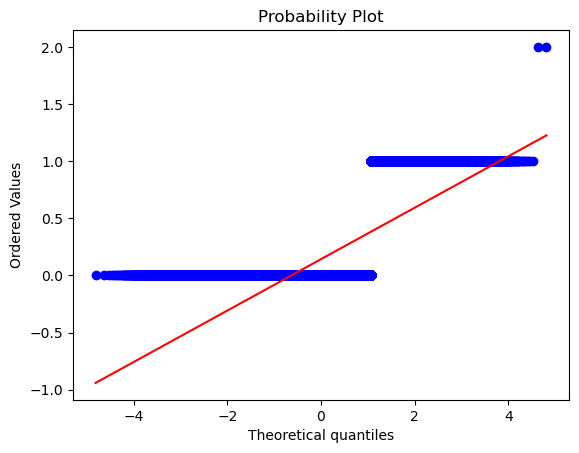

Column: seatsRemaining


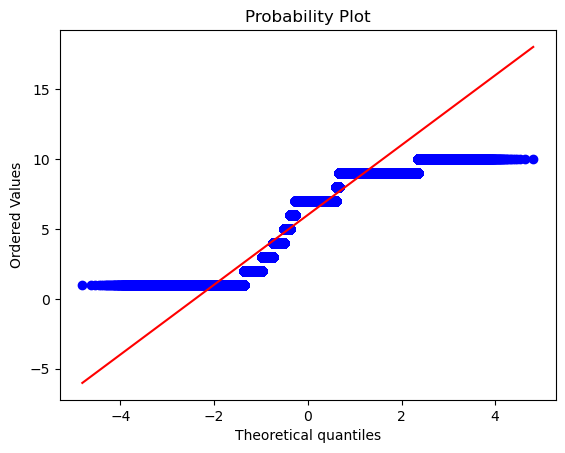

Column: baseFare


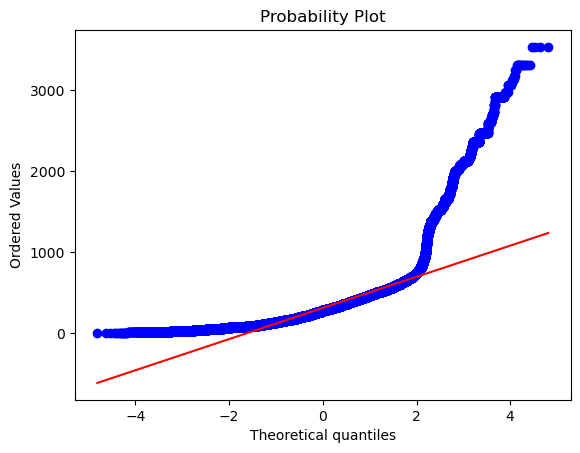

Column: totalFare


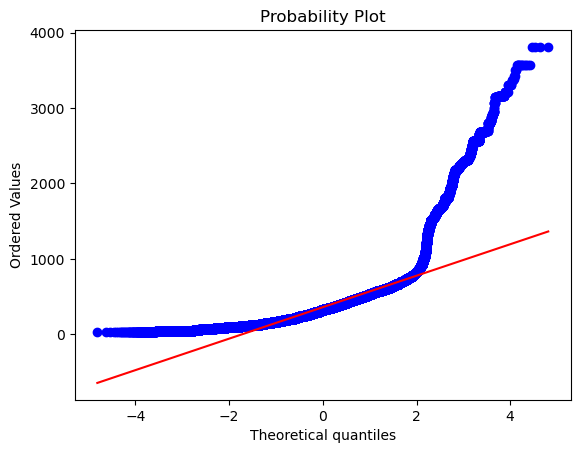

Column: totalTravelDistance


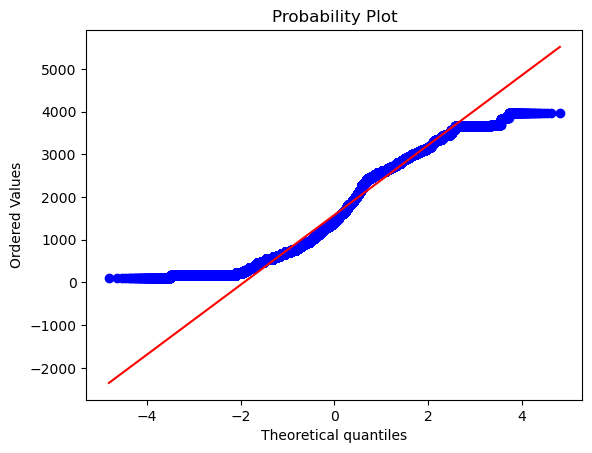

In [52]:
for column in numeric_with_zeroes_columns:
    print(f'Column: {column}')
    quantile_quantile_plot(df, column)

for column in numeric_without_zeroes_columns:
    print(f'Column: {column}')
    quantile_quantile_plot(df, column)

### 5. Определение выбросов <a class="anchor" id="5"></a>

[Перейти к содержанию](#content)

Прежде чем удалить выбросы, необходимо сначала решить, что считается выбросом. Есть два распространенных способа сделать это:
1. **Использование межквартильного диапазона**

Межквартильный размах (IQR) — это разница между 75-м процентилем (Q3) и 25-м процентилем (Q1) в наборе данных. Он измеряет разброс средних 50% значений.

Наблюдение можно определить как выброс, если оно в 1,5 раза превышает межквартильный размах, превышающий третий квартиль (Q3), или в 1,5 раза превышает межквартильный размах, меньше первого квартиля (Q1).

**Выбросы = наблюдения > Q3 + 1,5*IQR или Q1 – 1,5*IQR**
   
2. **Использование z-значения**

Z-оценка показывает, сколько стандартных отклонений данного значения от среднего. Используем следующую формулу для расчета z-показателя:

z = (X - μ) / σ

где:
- X — это одно необработанное значение данных;
- μ - среднее значение населения;
- σ - стандартное отклонение населения.

Можно определить наблюдение как выброс, если его z-оценка меньше -3 или больше 3.

**Выбросы = наблюдения с z-показателями > 3 или < -3**

Источники:

https://www.codecamp.ru/blog/remove-outliers-python/ <br />
https://benalexkeen.com/introduction-to-pyspark-part-4/

**Метод Z-оценки**

In [53]:
def z_estimation(df, column):
    z_values_column_name = 'z'
    row_idx_column_name = 'row_idx'
    
    data = np.array(df.select(collect_list(column)).first()[0])
    z = np.abs(scipy_stats.zscore(data))

    df_clean = spark.createDataFrame(z, [z_values_column_name])
    df = df.withColumn(row_idx_column_name, row_number().over(Window.orderBy(monotonically_increasing_id())))
    df_clean = df_clean.withColumn(row_idx_column_name, row_number().over(Window.orderBy(monotonically_increasing_id())))
    df_clean = df.join(df_clean, df.row_idx == df_clean.row_idx)
    
    return df_clean.filter(col(z_values_column_name) < 3).drop(row_idx_column_name, z_values_column_name)

In [54]:
z = {}

df_z = df

for column in numeric_with_zeroes_columns:
    df_z = z_estimation(df_z, column)
    print(f"""
        Column: {column}
          -- Cleaned: {df.count()} - {df_z.count()} = {df.count() - df_z.count()}
        """)

for column in numeric_without_zeroes_columns:
    df_z = z_estimation(df_z, column)
    print(f"""
        Column: {column}
          -- Cleaned: {df.count()} - {df_z.count()} = {df.count() - df_z.count()}
        """)

print(f'Total cleaned: {df.count()} - {df_z.count()} = {df.count() - df_z.count()}')


        Column: elapsedDays
          -- Cleaned: 921949 - 921947 = 2
        

        Column: seatsRemaining
          -- Cleaned: 921949 - 921947 = 2
        

        Column: baseFare
          -- Cleaned: 921949 - 908742 = 13207
        

        Column: totalFare
          -- Cleaned: 921949 - 902893 = 19056
        

        Column: totalTravelDistance
          -- Cleaned: 921949 - 902893 = 19056
        
Total cleaned: 921949 - 902893 = 19056


**Метод межквартильного диапазона**

In [55]:
def interquantile_range(df, column):
    quantileProbabilities = [0.25, 0.5, 0.75]
    quantiles = df.approxQuantile(column, quantileProbabilities, 0.01)
    
    quantile25th = quantiles[0]
    median = quantiles[1]
    quantile75th = quantiles[2]
    
    data = np.array(df.select(collect_list(column)).first()[0])
    iqr = np.array(scipy_stats.iqr(data))
    
    df_clean = df.filter(~((col(column) < (quantile25th - 1.5*iqr)) | (col(column) > (quantile75th + 1.5*iqr))))

    return (df_clean, quantile25th, median, quantile75th, iqr)

In [56]:
quantiles = {}

df_quantiles = df

for column in numeric_with_zeroes_columns:
    quantiles_info = interquantile_range(df_quantiles, column)
    df_quantiles = quantiles_info[0]
    quantiles[column] = quantiles_info[1:]
    print(f"""
        Column: {column}
          -- Cleaned: {df.count()} - {df_quantiles.count()} = {df.count() - df_quantiles.count()}
        """)

for column in numeric_without_zeroes_columns:
    quantiles_info = interquantile_range(df_quantiles, column)
    df_quantiles = quantiles_info[0]
    quantiles[column] = quantiles_info[1:]
    print(f"""
        Column: {column}
          -- Cleaned: {df.count()} - {df_quantiles.count()} = {df.count() - df_quantiles.count()}
        """)

for key, value in quantiles.items():
    print(f"""
            Column: {key}
              -- Quantile 25th: {value[0]}
              -- Median: {value[1]}
              -- Quantile 75th: {value[2]}
              -- IQR: {value[3]}
        """)

print(f'Total cleaned: {df.count()} - {df_quantiles.count()} = {df.count() - df_quantiles.count()}')


        Column: elapsedDays
          -- Cleaned: 921949 - 790615 = 131334
        

        Column: seatsRemaining
          -- Cleaned: 921949 - 790615 = 131334
        

        Column: baseFare
          -- Cleaned: 921949 - 773580 = 148369
        

        Column: totalFare
          -- Cleaned: 921949 - 772284 = 149665
        

        Column: totalTravelDistance
          -- Cleaned: 921949 - 772253 = 149696
        

            Column: elapsedDays
              -- Quantile 25th: 0.0
              -- Median: 0.0
              -- Quantile 75th: 0.0
              -- IQR: 0.0
        

            Column: seatsRemaining
              -- Quantile 25th: 4.0
              -- Median: 7.0
              -- Quantile 75th: 8.0
              -- IQR: 5.0
        

            Column: baseFare
              -- Quantile 25th: 164.65
              -- Median: 264.19
              -- Quantile 75th: 386.05
              -- IQR: 224.35999999999999
        

            Column: totalFare
       

Как можно увидеть, **метод межквартильного диапазона** убирает довольно большую часть данных, так как граница в 75%, выше которой данные считаются аномальными, в случае, например, с elapsedDays, является довольно грубой. Конкретно с текущим датасетом использование данного метода не является наилучшим.

**Метод Z-оценки** является более оптимальным, поскольку обнаруживает действительно слишком отличающиеся значения.

### 6. Корреляции между признаками <a class="anchor" id="6"></a>

[Перейти к содержанию](#content)

Чтобы выявить связи между признаками, можно построить матрицу корреляций, но сперва преобразуем категориальные признаки в числовые.

In [57]:
string_to_numeric_columns = [
    'startingAirport', 'destinationAirport', 'fareBasisCode', 'travelDuration', 
    'segmentsArrivalAirportCode', 'segmentsDepartureAirportCode',
    'segmentsAirlineName', 'segmentsAirlineCode', 'segmentsEquipmentDescription',
    'segmentsDurationInSeconds', 'segmentsDistance', 'segmentsCabinCode'
]

string_to_numeric_columns_index = [f'{column}Index' for column in string_to_numeric_columns]

indexer = StringIndexer(inputCols=string_to_numeric_columns, outputCols=string_to_numeric_columns_index)
indexed = indexer.setHandleInvalid('keep').fit(df_z).transform(df_z)

In [58]:
print('Data overview')
indexed.printSchema()

print('Columns overview')
pd.DataFrame(indexed.dtypes, columns = ['Column Name', 'Data type'])

Data overview
root
 |-- legId: string (nullable = true)
 |-- searchDate: date (nullable = true)
 |-- flightDate: date (nullable = true)
 |-- startingAirport: string (nullable = true)
 |-- destinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- travelDuration: string (nullable = true)
 |-- elapsedDays: integer (nullable = true)
 |-- isBasicEconomy: boolean (nullable = true)
 |-- isRefundable: boolean (nullable = true)
 |-- isNonStop: boolean (nullable = true)
 |-- baseFare: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: integer (nullable = true)
 |-- totalTravelDistance: integer (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeEpochSeconds: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDeparture

,Column Name,Data type
0,legId,string
1,searchDate,date
2,flightDate,date
3,startingAirport,string
4,destinationAirport,string
5,fareBasisCode,string
6,travelDuration,string
7,elapsedDays,int
8,isBasicEconomy,boolean
9,isRefundable,boolean


<Figure size 1600x500 with 0 Axes>

<Axes: >

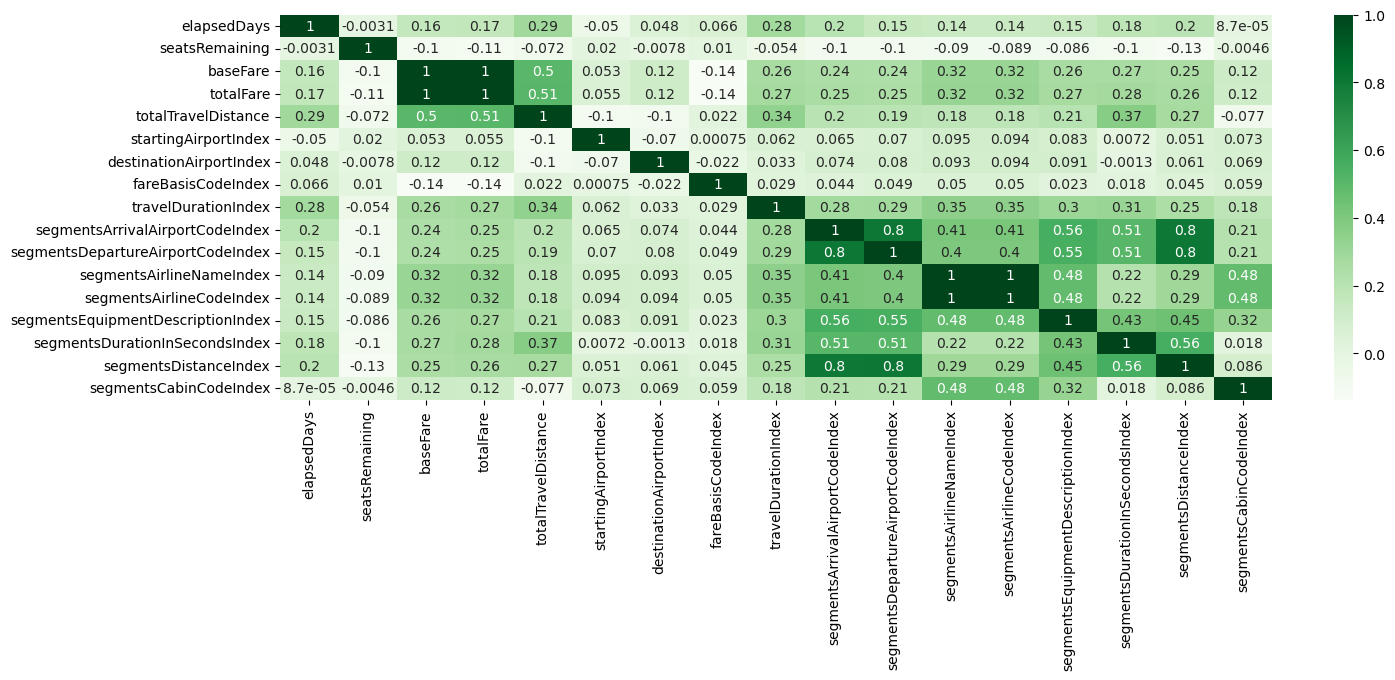

In [59]:
vector_col = 'corr_features'
numeric_columns = numeric_with_zeroes_columns + numeric_without_zeroes_columns + string_to_numeric_columns_index

assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_col)
df_vector = assembler.transform(indexed).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col).collect()[0][0]
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns=numeric_columns, index=numeric_columns) 

plt.figure(figsize=(16,5))  
sns.heatmap(
    corr_matrix_df, 
    xticklabels=corr_matrix_df.columns.values,
    yticklabels=corr_matrix_df.columns.values,  
    cmap='Greens', 
    annot=True
)

Как видно из корреляционной матрицы:
- `baseFare` и `totalFare` имеют сильную положительную корреляцию, поскольку, очевидно, что на одну и ту же цену билета всегда будет одна и та же сумма налогов;
- `baseFare`, `totalFare` и `totalTravelDistance` имеют среднюю положительную корреляцию, так как цена билета в основном зависит от общего пройденного расстояния;
- `segmentsAirlineNameIndex` и `segmentsAirlineCodeIndex` имеют сильную положительную корреляцию, поскольку, очевидно, что название авиакомпании всегда будет имеет один и тот же код авиакомпании;
- `segmentsArrivalAirportCodeIndex`, `segmentsDepartureAirportCodeIndex` и `segmentsDistanceIndex` имеют сильную положительную корреляцию, так как расстояние между местом отправления и местом прибытия от рейса к рейсу примерно одно и то же... 

### Выводы

В ходе лабораторной работы был проведен разведочный анализ данных с помощью PySpark: определены типы признаков в датасете, устранены пропущенные значения и выбросы, рассчитаны статистические показатели признаков, визуализированы распределение наиболее важных признаков и корреляция между ними. 